In [0]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Fake Review Detection with BERT on TF Hub

If you’ve been following Natural Language Processing over the past year, you’ve probably heard of BERT: Bidirectional Encoder Representations from Transformers. It’s a neural network architecture designed by Google researchers that’s totally transformed what’s state-of-the-art for NLP tasks, like text classification, translation, summarization, and question answering.

Now that BERT's been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, it's easy(ish) to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases.

Here, we'll train a model to predict whether an IMDB movie review is positive or negative using BERT in Tensorflow with tf hub. Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb). Let's get started!

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [3]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 10.4MB/s 


In [4]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. If you're running this code in Google's hosted Colab, the directory won't persist after the Colab session ends.

Alternatively, if you're a GCP user, you can store output in a GCP bucket. To do that, set a directory name in OUTPUT_DIR and the name of the GCP bucket in the BUCKET field.

Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

In [5]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'OUTPUT_DIR_NAME3'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: OUTPUT_DIR_NAME3 *****


#Data

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/training_matrix.csv')
valid = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/validating_matrix.csv')
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/testing_matrix.csv')

In [8]:
train.head

<bound method NDFrame.head of              date  user_id  ...  title_word_count upper_case_word_count
0      2011-08-11    25002  ...                 3                     0
1      2011-03-22     7756  ...                11                     6
2      2011-02-11   139209  ...                13                     4
3      2011-07-30     2400  ...                13                     2
4      2011-05-23    32189  ...                10                     4
...           ...      ...  ...               ...                   ...
11119  2011-12-31    49996  ...                 6                     2
11120  2011-12-31    93088  ...                 2                     1
11121  2011-12-31    89621  ...                 4                     2
11122  2011-12-31   117284  ...                 2                     1
11123  2011-12-31    46249  ...                29                     3

[11124 rows x 13 columns]>

In [0]:
train.loc[train.label == 1, 'label'] = 0
train.loc[train.label == -1, 'label'] = 1

valid.loc[valid.label == 1, 'label'] = 0
valid.loc[valid.label == -1, 'label'] = 1

test.loc[test.label == 1, 'label'] = 0
test.loc[test.label == -1, 'label'] = 1

In [0]:
import string
train['char_count'] = train['review'].apply(len)
train['word_count'] = train['review'].apply(lambda x: len(x.split()))
train['word_density'] = train['char_count'] / (train['word_count']+1)
train['punctuation_count'] = train['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train['title_word_count'] = train['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['upper_case_word_count'] = train['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

valid['char_count'] = valid['review'].apply(len)
valid['word_count'] = valid['review'].apply(lambda x: len(x.split()))
valid['word_density'] = valid['char_count'] / (valid['word_count']+1)
valid['punctuation_count'] = valid['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
valid['title_word_count'] = valid['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
valid['upper_case_word_count'] = valid['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

test['char_count'] = test['review'].apply(len)
test['word_count'] = test['review'].apply(lambda x: len(x.split()))
test['word_density'] = test['char_count'] / (test['word_count']+1)
test['punctuation_count'] = test['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
test['title_word_count'] = test['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test['upper_case_word_count'] = test['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))




In [11]:
# reviewer_centric features #
#train.user_id.value_counts()

train['date.1'] = pd.to_datetime(train['date.1'])
train['day_of_week'] = train['date.1'].dt.day_name()
#train.day_of_week.value_counts()[:10]]
dofw = train.day_of_week.unique()
for day in range(len(dofw)):
        label=train['label'][train.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        
        print("***********Day is ",dofw[day])
        print("fake is ",fake)
        print("real is ",real)
        print("tot is ",fake+real)
        print("Ratio is ",100*(fake/(fake+real)))
        print("len is ",len(label))

train['user_id_no_of_review'] = train.groupby('user_id')['user_id'].transform('size')
train['user_id_ave_rating'] = train.groupby('user_id')['rating'].transform('mean')
#train['user_id_std_rating'] = train.groupby('user_id')['rating'].transform('std')
train['user_id_ave_no_words'] = train.groupby('user_id')['word_count'].transform('mean')
train['user_id_max_review_a_day'] = train['user_id_no_of_review']
grouped = train.groupby('user_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    train.loc[train.user_id == name,'user_id_max_review_a_day'] = df2
    #group['user_id_max_review_a_day']=df2

#train[:][train.user_id==9236].sort_index(axis = 0)
    
valid['date.1'] = pd.to_datetime(valid['date.1'])
valid['day_of_week'] = valid['date.1'].dt.day_name()
#valid.day_of_week.value_counts()[:10]]
dofw = valid.day_of_week.unique()
for day in range(len(dofw)):
        label=valid['label'][valid.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        
        print("***********Day is ",dofw[day])
        print("fake is ",fake)
        print("real is ",real)
        print("tot is ",fake+real)
        print("Ratio is ",100*(fake/(fake+real)))
        print("len is ",len(label))

valid['user_id_no_of_review'] = valid.groupby('user_id')['user_id'].transform('size')
valid['user_id_ave_rating'] = valid.groupby('user_id')['rating'].transform('mean')
#valid['user_id_std_rating'] = valid.groupby('user_id')['rating'].transform('std')
valid['user_id_ave_no_words'] = valid.groupby('user_id')['word_count'].transform('mean')
valid['user_id_max_review_a_day'] = valid['user_id_no_of_review']
grouped = valid.groupby('user_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    valid.loc[valid.user_id == name,'user_id_max_review_a_day'] = df2
    #group['user_id_max_review_a_day']=df2

#valid[:][valid.user_id==9236].sort_index(axis = 0) 

test['date.1'] = pd.to_datetime(test['date.1'])
test['day_of_week'] = test['date.1'].dt.day_name()
#test.day_of_week.value_counts()[:10]]
dofw = test.day_of_week.unique()
for day in range(len(dofw)):
        label=test['label'][test.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        
        print("***********Day is ",dofw[day])
        print("fake is ",fake)
        print("real is ",real)
        print("tot is ",fake+real)
        print("Ratio is ",100*(fake/(fake+real)))
        print("len is ",len(label))

test['user_id_no_of_review'] = test.groupby('user_id')['user_id'].transform('size')
test['user_id_ave_rating'] = test.groupby('user_id')['rating'].transform('mean')
#test['user_id_std_rating'] = test.groupby('user_id')['rating'].transform('std')
test['user_id_ave_no_words'] = test.groupby('user_id')['word_count'].transform('mean')
test['user_id_max_review_a_day'] = test['user_id_no_of_review']
grouped = test.groupby('user_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    test.loc[test.user_id == name,'user_id_max_review_a_day'] = df2
    #group['user_id_max_review_a_day']=df2

#test[:][test.user_id==9236].sort_index(axis = 0) 

***********Day is  Thursday
fake is  764
real is  755
tot is  1519
Ratio is  50.29624753127058
len is  1519
***********Day is  Tuesday
fake is  800
real is  788
tot is  1588
Ratio is  50.377833753148614
len is  1588
***********Day is  Friday
fake is  758
real is  701
tot is  1459
Ratio is  51.953392734749826
len is  1459
***********Day is  Saturday
fake is  756
real is  744
tot is  1500
Ratio is  50.4
len is  1500
***********Day is  Monday
fake is  858
real is  913
tot is  1771
Ratio is  48.4472049689441
len is  1771
***********Day is  Sunday
fake is  790
real is  903
tot is  1693
Ratio is  46.66272888363851
len is  1693
***********Day is  Wednesday
fake is  836
real is  758
tot is  1594
Ratio is  52.446675031367626
len is  1594
***********Day is  Tuesday
fake is  150
real is  161
tot is  311
Ratio is  48.231511254019296
len is  311
***********Day is  Thursday
fake is  129
real is  128
tot is  257
Ratio is  50.19455252918288
len is  257
***********Day is  Saturday
fake is  137
real is 

In [0]:
# product_centric features #
#train.prod_id.value_counts()

train['prod_id_no_of_review'] = train.groupby('prod_id')['prod_id'].transform('size') + 1000.
train['prod_id_ave_rating'] = train.groupby('prod_id')['rating'].transform('mean') + 1000.
#train['prod_id_std_rating'] = train.groupby('prod_id')['rating'].transform('std') + 1000.
train['prod_id_ave_no_words'] = train.groupby('prod_id')['word_count'].transform('mean') + 1000.
train['prod_id_max_review_a_day'] = train['prod_id_no_of_review'] + 1000.
grouped = train.groupby('prod_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    train.loc[train.prod_id == name,'prod_id_max_review_a_day'] = df2 + 1000.
    #group['prod_id_max_review_a_day']=df2

#train[:][train.prod_id==9236].sort_index(axis = 0)

valid['prod_id_no_of_review'] = valid.groupby('prod_id')['prod_id'].transform('size') + 1000.
valid['prod_id_ave_rating'] = valid.groupby('prod_id')['rating'].transform('mean') + 1000.
#valid['prod_id_std_rating'] = valid.groupby('prod_id')['rating'].transform('std') + 1000.
valid['prod_id_ave_no_words'] = valid.groupby('prod_id')['word_count'].transform('mean') + 1000.
valid['prod_id_max_review_a_day'] = valid['prod_id_no_of_review']
grouped = valid.groupby('prod_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    valid.loc[valid.prod_id == name,'prod_id_max_review_a_day'] = df2 + 1000.
    #group['prod_id_max_review_a_day']=df2

#valid[:][valid.prod_id==9236].sort_index(axis = 0)  

test['prod_id_no_of_review'] = test.groupby('prod_id')['prod_id'].transform('size') + 1000.
test['prod_id_ave_rating'] = test.groupby('prod_id')['rating'].transform('mean') + 1000.
#test['prod_id_std_rating'] = test.groupby('prod_id')['rating'].transform('std') + 1000.
test['prod_id_ave_no_words'] = test.groupby('prod_id')['word_count'].transform('mean') + 1000.
test['prod_id_max_review_a_day'] = test['prod_id_no_of_review']
grouped = test.groupby('prod_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    test.loc[test.prod_id == name,'prod_id_max_review_a_day'] = df2 + 1000.
    #group['prod_id_max_review_a_day']=df2

#test[:][test.prod_id==9236].sort_index(axis = 0)  

In [0]:
train['total']=train.user_id.astype(str) + ' '+ train.prod_id.astype(str) + ' ' + train.rating.astype(str) + ' '+ \
train.user_id_no_of_review.astype(str) + ' ' + train.user_id_ave_rating.astype(str) + ' '+\
train.user_id_ave_no_words.astype(str) + ' ' + train.user_id_max_review_a_day.astype(str) + ' '+\
train.prod_id_no_of_review.astype(str) + ' ' + train.prod_id_ave_rating.astype(str) + ' '+\
train.prod_id_ave_no_words.astype(str) + ' ' + train.prod_id_max_review_a_day.astype(str) + ' '+\
train.day_of_week.astype(str) + ' '+train.review  

#train['total']=train.user_id.astype(str) + ' '+ train.prod_id.astype(str) + ' ' + train.rating.astype(str) + ' '+  train.review
#test['total']=test.user_id.astype(str) + ' '+ test.prod_id.astype(str) + ' ' + test.rating.astype(str) + ' '+test.review

valid['total']=valid.user_id.astype(str) + ' '+ valid.prod_id.astype(str) + ' ' + valid.rating.astype(str) + ' '+ \
valid.user_id_no_of_review.astype(str) + ' ' + valid.user_id_ave_rating.astype(str) + ' '+\
valid.user_id_ave_no_words.astype(str) + ' ' + valid.user_id_max_review_a_day.astype(str) + ' '+\
valid.prod_id_no_of_review.astype(str) + ' ' + valid.prod_id_ave_rating.astype(str) + ' '+\
valid.prod_id_ave_no_words.astype(str) + ' ' + valid.prod_id_max_review_a_day.astype(str) + ' '+\
valid.day_of_week.astype(str) + ' '+ valid.review  

test['total']=test.user_id.astype(str) + ' '+ test.prod_id.astype(str) + ' ' + test.rating.astype(str) + ' '+ \
test.user_id_no_of_review.astype(str) + ' ' + test.user_id_ave_rating.astype(str) + ' '+\
test.user_id_ave_no_words.astype(str) + ' ' + test.user_id_max_review_a_day.astype(str) + ' '+\
test.prod_id_no_of_review.astype(str) + ' ' + test.prod_id_ave_rating.astype(str) + ' '+\
test.prod_id_ave_no_words.astype(str) + ' ' + test.prod_id_max_review_a_day.astype(str) + ' '+\
test.day_of_week.astype(str) + ' '+ test.review  

First, let's download the dataset, hosted by Stanford. The code below, which downloads, extracts, and imports the IMDB Large Movie Review Dataset, is borrowed from [this Tensorflow tutorial](https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub).

In [14]:
test.total.head

<bound method NDFrame.head of 0       102359 514 5.0 1 5.0 7.0 1 1013.0 1003.4615384...
1       45961 763 5.0 1 5.0 76.0 1 1002.0 1005.0 1044....
2       78578 379 5.0 1 5.0 211.0 1 1021.0 1004.333333...
3       85624 419 5.0 1 5.0 19.0 1 1007.0 1003.7142857...
4       33686 101 4.0 1 4.0 14.0 1 1032.0 1004.375 107...
                              ...                        
9995    21818 841 3.0 1 3.0 513.0 1 1058.0 1003.396551...
9996    7790 706 4.0 1 4.0 300.0 1 1017.0 1003.8235294...
9997    101508 540 4.0 1 4.0 51.0 1 1009.0 1004.111111...
9998    8119 914 4.0 1 4.0 45.0 1 1015.0 1003.8 1116.3...
9999    3521 453 3.0 2 3.5 95.5 1 1025.0 1003.68 1157....
Name: total, Length: 10000, dtype: object>

To keep train fast, we'll take a sample of 5000 train and test examples, respectively.

In [15]:
train.columns

Index(['date', 'user_id', 'prod_id', 'date.1', 'review', 'label', 'rating',
       'char_count', 'word_count', 'word_density', 'punctuation_count',
       'title_word_count', 'upper_case_word_count', 'day_of_week',
       'user_id_no_of_review', 'user_id_ave_rating', 'user_id_ave_no_words',
       'user_id_max_review_a_day', 'prod_id_no_of_review',
       'prod_id_ave_rating', 'prod_id_ave_no_words',
       'prod_id_max_review_a_day', 'total'],
      dtype='object')

In [0]:
from sklearn.utils import shuffle
train = shuffle(train, random_state=0)
valid = shuffle(valid, random_state=0)
test = shuffle(test, random_state=0)

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [0]:
DATA_COLUMN = 'total'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

valid_InputExamples = valid.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [19]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [20]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [21]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
valid_features = bert.run_classifier.convert_examples_to_features(valid_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 11124


INFO:tensorflow:Writing example 0 of 11124


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 42 ##7 ##75 81 ##4 4 . 0 5 2 . 8 289 . 0 2 102 ##3 . 0 100 ##4 . 43 ##47 ##8 ##26 ##0 ##86 ##9 ##56 109 ##5 . 130 ##43 ##47 ##8 ##26 ##0 ##8 ##7 100 ##1 . 0 thursday i have been meaning to write a review for a while now because i was so happy with the meal i ate here the day after valentine ##s day . my girlfriend and i went , we both wait tables and decided to make money on v - day then spend it the night after . the atmosphere was awesome , i love the lodge ##y rustic feel . the waits ##taff was informed but not pre ##ten ##tious [SEP]


INFO:tensorflow:tokens: [CLS] 42 ##7 ##75 81 ##4 4 . 0 5 2 . 8 289 . 0 2 102 ##3 . 0 100 ##4 . 43 ##47 ##8 ##26 ##0 ##86 ##9 ##56 109 ##5 . 130 ##43 ##47 ##8 ##26 ##0 ##8 ##7 100 ##1 . 0 thursday i have been meaning to write a review for a while now because i was so happy with the meal i ate here the day after valentine ##s day . my girlfriend and i went , we both wait tables and decided to make money on v - day then spend it the night after . the atmosphere was awesome , i love the lodge ##y rustic feel . the waits ##taff was informed but not pre ##ten ##tious [SEP]


INFO:tensorflow:input_ids: 101 4413 2581 23352 6282 2549 1018 1012 1014 1019 1016 1012 1022 27054 1012 1014 1016 9402 2509 1012 1014 2531 2549 1012 4724 22610 2620 23833 2692 20842 2683 26976 11518 2629 1012 7558 23777 22610 2620 23833 2692 2620 2581 2531 2487 1012 1014 9432 1045 2031 2042 3574 2000 4339 1037 3319 2005 1037 2096 2085 2138 1045 2001 2061 3407 2007 1996 7954 1045 8823 2182 1996 2154 2044 10113 2015 2154 1012 2026 6513 1998 1045 2253 1010 2057 2119 3524 7251 1998 2787 2000 2191 2769 2006 1058 1011 2154 2059 5247 2009 1996 2305 2044 1012 1996 7224 2001 12476 1010 1045 2293 1996 7410 2100 27471 2514 1012 1996 18074 22542 2001 6727 2021 2025 3653 6528 20771 102


INFO:tensorflow:input_ids: 101 4413 2581 23352 6282 2549 1018 1012 1014 1019 1016 1012 1022 27054 1012 1014 1016 9402 2509 1012 1014 2531 2549 1012 4724 22610 2620 23833 2692 20842 2683 26976 11518 2629 1012 7558 23777 22610 2620 23833 2692 2620 2581 2531 2487 1012 1014 9432 1045 2031 2042 3574 2000 4339 1037 3319 2005 1037 2096 2085 2138 1045 2001 2061 3407 2007 1996 7954 1045 8823 2182 1996 2154 2044 10113 2015 2154 1012 2026 6513 1998 1045 2253 1010 2057 2119 3524 7251 1998 2787 2000 2191 2769 2006 1058 1011 2154 2059 5247 2009 1996 2305 2044 1012 1996 7224 2001 12476 1010 1045 2293 1996 7410 2100 27471 2514 1012 1996 18074 22542 2001 6727 2021 2025 3653 6528 20771 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 39 ##6 ##8 ##4 211 2 . 0 2 3 . 5 23 . 0 1 109 ##9 . 0 100 ##3 . 76 ##7 ##6 ##7 ##6 ##7 ##6 ##7 ##6 ##7 ##6 ##8 107 ##8 . 49 ##49 ##49 ##49 ##49 ##49 ##4 100 ##3 . 0 wednesday yu ##ck ! ! i waited in line along with a troop of un ##bat ##hed hips ##ters only to have the gr ##ea ##sies ##t pizza coming out of the b rated health hazard . . . . 2 stars for simply being a pizza spot . [SEP]


INFO:tensorflow:tokens: [CLS] 39 ##6 ##8 ##4 211 2 . 0 2 3 . 5 23 . 0 1 109 ##9 . 0 100 ##3 . 76 ##7 ##6 ##7 ##6 ##7 ##6 ##7 ##6 ##7 ##6 ##8 107 ##8 . 49 ##49 ##49 ##49 ##49 ##49 ##4 100 ##3 . 0 wednesday yu ##ck ! ! i waited in line along with a troop of un ##bat ##hed hips ##ters only to have the gr ##ea ##sies ##t pizza coming out of the b rated health hazard . . . . 2 stars for simply being a pizza spot . [SEP]


INFO:tensorflow:input_ids: 101 4464 2575 2620 2549 19235 1016 1012 1014 1016 1017 1012 1019 2603 1012 1014 1015 11518 2683 1012 1014 2531 2509 1012 6146 2581 2575 2581 2575 2581 2575 2581 2575 2581 2575 2620 10550 2620 1012 4749 26224 26224 26224 26224 26224 2549 2531 2509 1012 1014 9317 9805 3600 999 999 1045 4741 1999 2240 2247 2007 1037 10123 1997 4895 14479 9072 6700 7747 2069 2000 2031 1996 24665 5243 14625 2102 10733 2746 2041 1997 1996 1038 6758 2740 15559 1012 1012 1012 1012 1016 3340 2005 3432 2108 1037 10733 3962 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4464 2575 2620 2549 19235 1016 1012 1014 1016 1017 1012 1019 2603 1012 1014 1015 11518 2683 1012 1014 2531 2509 1012 6146 2581 2575 2581 2575 2581 2575 2581 2575 2581 2575 2620 10550 2620 1012 4749 26224 26224 26224 26224 26224 2549 2531 2509 1012 1014 9317 9805 3600 999 999 1045 4741 1999 2240 2247 2007 1037 10123 1997 4895 14479 9072 6700 7747 2069 2000 2031 1996 24665 5243 14625 2102 10733 2746 2041 1997 1996 1038 6758 2740 15559 1012 1012 1012 1012 1016 3340 2005 3432 2108 1037 10733 3962 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 1862 ##9 590 4 . 0 1 4 . 0 187 . 0 1 101 ##9 . 0 100 ##4 . 05 ##26 ##31 ##57 ##8 ##9 ##47 ##4 110 ##5 . 89 ##47 ##36 ##8 ##42 ##10 ##52 100 ##1 . 0 friday after failing to elbow our way through the insane crowds at the halloween parade , my friend and i decided to retreat to a nice and qu ##aint restaurant for some proper food . this small and cozy establishment definitely made up for our disappointing halloween parade experience ! i had : atlantic cod - a french - japanese fusion fish dish containing supreme - quality shit ##ake mushrooms bas ##king in an equally supreme - tasting mushroom bro ##th my friend [SEP]


INFO:tensorflow:tokens: [CLS] 1862 ##9 590 4 . 0 1 4 . 0 187 . 0 1 101 ##9 . 0 100 ##4 . 05 ##26 ##31 ##57 ##8 ##9 ##47 ##4 110 ##5 . 89 ##47 ##36 ##8 ##42 ##10 ##52 100 ##1 . 0 friday after failing to elbow our way through the insane crowds at the halloween parade , my friend and i decided to retreat to a nice and qu ##aint restaurant for some proper food . this small and cozy establishment definitely made up for our disappointing halloween parade experience ! i had : atlantic cod - a french - japanese fusion fish dish containing supreme - quality shit ##ake mushrooms bas ##king in an equally supreme - tasting mushroom bro ##th my friend [SEP]


INFO:tensorflow:input_ids: 101 6889 2683 25186 1018 1012 1014 1015 1018 1012 1014 19446 1012 1014 1015 7886 2683 1012 1014 2531 2549 1012 5709 23833 21486 28311 2620 2683 22610 2549 7287 2629 1012 6486 22610 21619 2620 20958 10790 25746 2531 2487 1012 1014 5958 2044 7989 2000 8999 2256 2126 2083 1996 9577 12783 2012 1996 14414 7700 1010 2026 2767 1998 1045 2787 2000 7822 2000 1037 3835 1998 24209 22325 4825 2005 2070 5372 2833 1012 2023 2235 1998 26931 5069 5791 2081 2039 2005 2256 15640 14414 7700 3325 999 1045 2018 1024 4448 19429 1011 1037 2413 1011 2887 10077 3869 9841 4820 4259 1011 3737 4485 13808 23827 19021 6834 1999 2019 8053 4259 1011 18767 18565 22953 2705 2026 2767 102


INFO:tensorflow:input_ids: 101 6889 2683 25186 1018 1012 1014 1015 1018 1012 1014 19446 1012 1014 1015 7886 2683 1012 1014 2531 2549 1012 5709 23833 21486 28311 2620 2683 22610 2549 7287 2629 1012 6486 22610 21619 2620 20958 10790 25746 2531 2487 1012 1014 5958 2044 7989 2000 8999 2256 2126 2083 1996 9577 12783 2012 1996 14414 7700 1010 2026 2767 1998 1045 2787 2000 7822 2000 1037 3835 1998 24209 22325 4825 2005 2070 5372 2833 1012 2023 2235 1998 26931 5069 5791 2081 2039 2005 2256 15640 14414 7700 3325 999 1045 2018 1024 4448 19429 1011 1037 2413 1011 2887 10077 3869 9841 4820 4259 1011 3737 4485 13808 23827 19021 6834 1999 2019 8053 4259 1011 18767 18565 22953 2705 2026 2767 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 75 ##18 319 4 . 0 1 4 . 0 78 . 0 1 102 ##2 . 0 100 ##4 . 04 ##54 ##54 ##54 ##54 ##54 ##5 112 ##4 . 227 ##27 ##27 ##27 ##27 ##27 100 ##1 . 0 tuesday i loved this place ! went here with my dinner club crew and had a great time . this place is super cute and cozy - decor is on point with very helpful and friendly staff . the food was delicious and very reasonably priced ! we went on a week night around 7 ##pm and had the place basically to ourselves , which was nice so our laughter didn ' t disturb anyone else . this place is definitely on my list of [SEP]


INFO:tensorflow:tokens: [CLS] 75 ##18 319 4 . 0 1 4 . 0 78 . 0 1 102 ##2 . 0 100 ##4 . 04 ##54 ##54 ##54 ##54 ##54 ##5 112 ##4 . 227 ##27 ##27 ##27 ##27 ##27 100 ##1 . 0 tuesday i loved this place ! went here with my dinner club crew and had a great time . this place is super cute and cozy - decor is on point with very helpful and friendly staff . the food was delicious and very reasonably priced ! we went on a week night around 7 ##pm and had the place basically to ourselves , which was nice so our laughter didn ' t disturb anyone else . this place is definitely on my list of [SEP]


INFO:tensorflow:input_ids: 101 4293 15136 26499 1018 1012 1014 1015 1018 1012 1014 6275 1012 1014 1015 9402 2475 1012 1014 2531 2549 1012 5840 27009 27009 27009 27009 27009 2629 11176 2549 1012 21489 22907 22907 22907 22907 22907 2531 2487 1012 1014 9857 1045 3866 2023 2173 999 2253 2182 2007 2026 4596 2252 3626 1998 2018 1037 2307 2051 1012 2023 2173 2003 3565 10140 1998 26931 1011 25545 2003 2006 2391 2007 2200 14044 1998 5379 3095 1012 1996 2833 2001 12090 1998 2200 16286 21125 999 2057 2253 2006 1037 2733 2305 2105 1021 9737 1998 2018 1996 2173 10468 2000 9731 1010 2029 2001 3835 2061 2256 7239 2134 1005 1056 22995 3087 2842 1012 2023 2173 2003 5791 2006 2026 2862 1997 102


INFO:tensorflow:input_ids: 101 4293 15136 26499 1018 1012 1014 1015 1018 1012 1014 6275 1012 1014 1015 9402 2475 1012 1014 2531 2549 1012 5840 27009 27009 27009 27009 27009 2629 11176 2549 1012 21489 22907 22907 22907 22907 22907 2531 2487 1012 1014 9857 1045 3866 2023 2173 999 2253 2182 2007 2026 4596 2252 3626 1998 2018 1037 2307 2051 1012 2023 2173 2003 3565 10140 1998 26931 1011 25545 2003 2006 2391 2007 2200 14044 1998 5379 3095 1012 1996 2833 2001 12090 1998 2200 16286 21125 999 2057 2253 2006 1037 2733 2305 2105 1021 9737 1998 2018 1996 2173 10468 2000 9731 1010 2029 2001 3835 2061 2256 7239 2134 1005 1056 22995 3087 2842 1012 2023 2173 2003 5791 2006 2026 2862 1997 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 45 ##6 ##32 70 ##2 3 . 0 1 3 . 0 74 . 0 1 104 ##6 . 0 100 ##3 . 73 ##9 ##13 ##0 ##43 ##47 ##8 ##26 106 ##5 . 1739 ##13 ##0 ##43 ##47 ##8 ##3 100 ##2 . 0 wednesday this is a good place to order from . in the summer it is great to sit in the back . i love the mango salad . all of the noodles are all good . with to ##fu or chicken . . . the beef is not good ( tough and no flavor ) . joy ##a is well priced and fast to deliver . it think it is pretty standard fair - clean , fresh and ta ##sty . [SEP]


INFO:tensorflow:tokens: [CLS] 45 ##6 ##32 70 ##2 3 . 0 1 3 . 0 74 . 0 1 104 ##6 . 0 100 ##3 . 73 ##9 ##13 ##0 ##43 ##47 ##8 ##26 106 ##5 . 1739 ##13 ##0 ##43 ##47 ##8 ##3 100 ##2 . 0 wednesday this is a good place to order from . in the summer it is great to sit in the back . i love the mango salad . all of the noodles are all good . with to ##fu or chicken . . . the beef is not good ( tough and no flavor ) . joy ##a is well priced and fast to deliver . it think it is pretty standard fair - clean , fresh and ta ##sty . [SEP]


INFO:tensorflow:input_ids: 101 3429 2575 16703 3963 2475 1017 1012 1014 1015 1017 1012 1014 6356 1012 1014 1015 9645 2575 1012 1014 2531 2509 1012 6421 2683 17134 2692 23777 22610 2620 23833 10114 2629 1012 25801 17134 2692 23777 22610 2620 2509 2531 2475 1012 1014 9317 2023 2003 1037 2204 2173 2000 2344 2013 1012 1999 1996 2621 2009 2003 2307 2000 4133 1999 1996 2067 1012 1045 2293 1996 24792 16521 1012 2035 1997 1996 27130 2024 2035 2204 1012 2007 2000 11263 2030 7975 1012 1012 1012 1996 12486 2003 2025 2204 1006 7823 1998 2053 14894 1007 1012 6569 2050 2003 2092 21125 1998 3435 2000 8116 1012 2009 2228 2009 2003 3492 3115 4189 1011 4550 1010 4840 1998 11937 21756 1012 102


INFO:tensorflow:input_ids: 101 3429 2575 16703 3963 2475 1017 1012 1014 1015 1017 1012 1014 6356 1012 1014 1015 9645 2575 1012 1014 2531 2509 1012 6421 2683 17134 2692 23777 22610 2620 23833 10114 2629 1012 25801 17134 2692 23777 22610 2620 2509 2531 2475 1012 1014 9317 2023 2003 1037 2204 2173 2000 2344 2013 1012 1999 1996 2621 2009 2003 2307 2000 4133 1999 1996 2067 1012 1045 2293 1996 24792 16521 1012 2035 1997 1996 27130 2024 2035 2204 1012 2007 2000 11263 2030 7975 1012 1012 1012 1996 12486 2003 2025 2204 1006 7823 1998 2053 14894 1007 1012 6569 2050 2003 2092 21125 1998 3435 2000 8116 1012 2009 2228 2009 2003 3492 3115 4189 1011 4550 1010 4840 1998 11937 21756 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 11124


INFO:tensorflow:Writing example 10000 of 11124


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 72 ##48 ##8 276 4 . 0 1 4 . 0 31 . 0 1 100 ##3 . 0 100 ##4 . 333 ##33 ##33 ##33 ##33 ##34 103 ##9 . 0 100 ##1 . 0 sunday had a good time here today with my family . food was very good , wine a bit over ##pr ##ice ##d . only down ##beat was the " mai ##tre ' d ' " - he kept ignoring us . would go again , though . [SEP]


INFO:tensorflow:tokens: [CLS] 72 ##48 ##8 276 4 . 0 1 4 . 0 31 . 0 1 100 ##3 . 0 100 ##4 . 333 ##33 ##33 ##33 ##33 ##34 103 ##9 . 0 100 ##1 . 0 sunday had a good time here today with my family . food was very good , wine a bit over ##pr ##ice ##d . only down ##beat was the " mai ##tre ' d ' " - he kept ignoring us . would go again , though . [SEP]


INFO:tensorflow:input_ids: 101 5824 18139 2620 25113 1018 1012 1014 1015 1018 1012 1014 2861 1012 1014 1015 2531 2509 1012 1014 2531 2549 1012 21211 22394 22394 22394 22394 22022 9800 2683 1012 1014 2531 2487 1012 1014 4465 2018 1037 2204 2051 2182 2651 2007 2026 2155 1012 2833 2001 2200 2204 1010 4511 1037 2978 2058 18098 6610 2094 1012 2069 2091 19442 2001 1996 1000 14736 7913 1005 1040 1005 1000 1011 2002 2921 9217 2149 1012 2052 2175 2153 1010 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5824 18139 2620 25113 1018 1012 1014 1015 1018 1012 1014 2861 1012 1014 1015 2531 2509 1012 1014 2531 2549 1012 21211 22394 22394 22394 22394 22022 9800 2683 1012 1014 2531 2487 1012 1014 4465 2018 1037 2204 2051 2182 2651 2007 2026 2155 1012 2833 2001 2200 2204 1010 4511 1037 2978 2058 18098 6610 2094 1012 2069 2091 19442 2001 1996 1000 14736 7913 1005 1040 1005 1000 1011 2002 2921 9217 2149 1012 2052 2175 2153 1010 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 91 ##60 ##5 45 ##6 5 . 0 1 5 . 0 59 . 0 1 100 ##6 . 0 100 ##3 . 5 106 ##6 . 0 100 ##1 . 0 thursday the food is excellent , we came in as a group of 10 , their crab cake is the best crab cakes i ever had , my husband ordered grill squid , oh , it is so yu ##mmy ! ! the special we ordered that night is excellent too , the service is good as well . i love this place , will def come back for more food ! [SEP]


INFO:tensorflow:tokens: [CLS] 91 ##60 ##5 45 ##6 5 . 0 1 5 . 0 59 . 0 1 100 ##6 . 0 100 ##3 . 5 106 ##6 . 0 100 ##1 . 0 thursday the food is excellent , we came in as a group of 10 , their crab cake is the best crab cakes i ever had , my husband ordered grill squid , oh , it is so yu ##mmy ! ! the special we ordered that night is excellent too , the service is good as well . i love this place , will def come back for more food ! [SEP]


INFO:tensorflow:input_ids: 101 6205 16086 2629 3429 2575 1019 1012 1014 1015 1019 1012 1014 5354 1012 1014 1015 2531 2575 1012 1014 2531 2509 1012 1019 10114 2575 1012 1014 2531 2487 1012 1014 9432 1996 2833 2003 6581 1010 2057 2234 1999 2004 1037 2177 1997 2184 1010 2037 18081 9850 2003 1996 2190 18081 22619 1045 2412 2018 1010 2026 3129 3641 18651 26852 1010 2821 1010 2009 2003 2061 9805 18879 999 999 1996 2569 2057 3641 2008 2305 2003 6581 2205 1010 1996 2326 2003 2204 2004 2092 1012 1045 2293 2023 2173 1010 2097 13366 2272 2067 2005 2062 2833 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6205 16086 2629 3429 2575 1019 1012 1014 1015 1019 1012 1014 5354 1012 1014 1015 2531 2575 1012 1014 2531 2509 1012 1019 10114 2575 1012 1014 2531 2487 1012 1014 9432 1996 2833 2003 6581 1010 2057 2234 1999 2004 1037 2177 1997 2184 1010 2037 18081 9850 2003 1996 2190 18081 22619 1045 2412 2018 1010 2026 3129 3641 18651 26852 1010 2821 1010 2009 2003 2061 9805 18879 999 999 1996 2569 2057 3641 2008 2305 2003 6581 2205 1010 1996 2326 2003 2204 2004 2092 1012 1045 2293 2023 2173 1010 2097 13366 2272 2067 2005 2062 2833 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 142 ##44 ##0 77 ##9 4 . 0 1 4 . 0 1 . 0 1 100 ##3 . 0 100 ##4 . 66 ##66 ##66 ##66 ##66 ##66 ##6 103 ##1 . 66 ##66 ##66 ##66 ##66 ##66 ##7 100 ##1 . 0 saturday nice [SEP]


INFO:tensorflow:tokens: [CLS] 142 ##44 ##0 77 ##9 4 . 0 1 4 . 0 1 . 0 1 100 ##3 . 0 100 ##4 . 66 ##66 ##66 ##66 ##66 ##66 ##6 103 ##1 . 66 ##66 ##66 ##66 ##66 ##66 ##7 100 ##1 . 0 saturday nice [SEP]


INFO:tensorflow:input_ids: 101 16087 22932 2692 6255 2683 1018 1012 1014 1015 1018 1012 1014 1015 1012 1014 1015 2531 2509 1012 1014 2531 2549 1012 5764 28756 28756 28756 28756 28756 2575 9800 2487 1012 5764 28756 28756 28756 28756 28756 2581 2531 2487 1012 1014 5095 3835 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16087 22932 2692 6255 2683 1018 1012 1014 1015 1018 1012 1014 1015 1012 1014 1015 2531 2509 1012 1014 2531 2549 1012 5764 28756 28756 28756 28756 28756 2575 9800 2487 1012 5764 28756 28756 28756 28756 28756 2581 2531 2487 1012 1014 5095 3835 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 1086 ##90 86 ##0 2 . 0 1 2 . 0 137 . 0 1 100 ##3 . 0 100 ##3 . 66 ##66 ##66 ##66 ##66 ##66 ##6 107 ##8 . 333 ##33 ##33 ##33 ##33 ##33 100 ##1 . 0 monday this was our first pizza stop in ny after we finished our statue of liberty tour . it was good but definitely not the best . first , the pizza pie ##s only come in one size forcing you to eat too much if there is only two of you or to take it home which we didn ' t want to do . there was a good variety of topping ##s ( and they had bro ##cco ##li , ya ##y ) [SEP]


INFO:tensorflow:tokens: [CLS] 1086 ##90 86 ##0 2 . 0 1 2 . 0 137 . 0 1 100 ##3 . 0 100 ##3 . 66 ##66 ##66 ##66 ##66 ##66 ##6 107 ##8 . 333 ##33 ##33 ##33 ##33 ##33 100 ##1 . 0 monday this was our first pizza stop in ny after we finished our statue of liberty tour . it was good but definitely not the best . first , the pizza pie ##s only come in one size forcing you to eat too much if there is only two of you or to take it home which we didn ' t want to do . there was a good variety of topping ##s ( and they had bro ##cco ##li , ya ##y ) [SEP]


INFO:tensorflow:input_ids: 101 28196 21057 6564 2692 1016 1012 1014 1015 1016 1012 1014 14989 1012 1014 1015 2531 2509 1012 1014 2531 2509 1012 5764 28756 28756 28756 28756 28756 2575 10550 2620 1012 21211 22394 22394 22394 22394 22394 2531 2487 1012 1014 6928 2023 2001 2256 2034 10733 2644 1999 6396 2044 2057 2736 2256 6231 1997 7044 2778 1012 2009 2001 2204 2021 5791 2025 1996 2190 1012 2034 1010 1996 10733 11345 2015 2069 2272 1999 2028 2946 6932 2017 2000 4521 2205 2172 2065 2045 2003 2069 2048 1997 2017 2030 2000 2202 2009 2188 2029 2057 2134 1005 1056 2215 2000 2079 1012 2045 2001 1037 2204 3528 1997 22286 2015 1006 1998 2027 2018 22953 21408 3669 1010 8038 2100 1007 102


INFO:tensorflow:input_ids: 101 28196 21057 6564 2692 1016 1012 1014 1015 1016 1012 1014 14989 1012 1014 1015 2531 2509 1012 1014 2531 2509 1012 5764 28756 28756 28756 28756 28756 2575 10550 2620 1012 21211 22394 22394 22394 22394 22394 2531 2487 1012 1014 6928 2023 2001 2256 2034 10733 2644 1999 6396 2044 2057 2736 2256 6231 1997 7044 2778 1012 2009 2001 2204 2021 5791 2025 1996 2190 1012 2034 1010 1996 10733 11345 2015 2069 2272 1999 2028 2946 6932 2017 2000 4521 2205 2172 2065 2045 2003 2069 2048 1997 2017 2030 2000 2202 2009 2188 2029 2057 2134 1005 1056 2215 2000 2079 1012 2045 2001 1037 2204 3528 1997 22286 2015 1006 1998 2027 2018 22953 21408 3669 1010 8038 2100 1007 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 55 ##26 ##9 65 ##5 1 . 0 1 1 . 0 175 . 0 1 100 ##5 . 0 100 ##3 . 0 113 ##7 . 6 100 ##1 . 0 monday * * * * * be ##ware of the host and waits ##taff * * * * * my date and i came here early on a saturday because we had heard great things . upon walking in , we were immediately acc ##ost ##ed by the host inter ##ro ##gating us on how long we would be . after sitting down and ordering drinks , we were constantly hound ##ed to order app ##eti ##zers and food . after finishing the meal and the last of our over ##pr ##ice ##d wine [SEP]


INFO:tensorflow:tokens: [CLS] 55 ##26 ##9 65 ##5 1 . 0 1 1 . 0 175 . 0 1 100 ##5 . 0 100 ##3 . 0 113 ##7 . 6 100 ##1 . 0 monday * * * * * be ##ware of the host and waits ##taff * * * * * my date and i came here early on a saturday because we had heard great things . upon walking in , we were immediately acc ##ost ##ed by the host inter ##ro ##gating us on how long we would be . after sitting down and ordering drinks , we were constantly hound ##ed to order app ##eti ##zers and food . after finishing the meal and the last of our over ##pr ##ice ##d wine [SEP]


INFO:tensorflow:input_ids: 101 4583 23833 2683 3515 2629 1015 1012 1014 1015 1015 1012 1014 12862 1012 1014 1015 2531 2629 1012 1014 2531 2509 1012 1014 12104 2581 1012 1020 2531 2487 1012 1014 6928 1008 1008 1008 1008 1008 2022 8059 1997 1996 3677 1998 18074 22542 1008 1008 1008 1008 1008 2026 3058 1998 1045 2234 2182 2220 2006 1037 5095 2138 2057 2018 2657 2307 2477 1012 2588 3788 1999 1010 2057 2020 3202 16222 14122 2098 2011 1996 3677 6970 3217 16961 2149 2006 2129 2146 2057 2052 2022 1012 2044 3564 2091 1998 13063 8974 1010 2057 2020 7887 19598 2098 2000 2344 10439 20624 16750 1998 2833 1012 2044 5131 1996 7954 1998 1996 2197 1997 2256 2058 18098 6610 2094 4511 102


INFO:tensorflow:input_ids: 101 4583 23833 2683 3515 2629 1015 1012 1014 1015 1015 1012 1014 12862 1012 1014 1015 2531 2629 1012 1014 2531 2509 1012 1014 12104 2581 1012 1020 2531 2487 1012 1014 6928 1008 1008 1008 1008 1008 2022 8059 1997 1996 3677 1998 18074 22542 1008 1008 1008 1008 1008 2026 3058 1998 1045 2234 2182 2220 2006 1037 5095 2138 2057 2018 2657 2307 2477 1012 2588 3788 1999 1010 2057 2020 3202 16222 14122 2098 2011 1996 3677 6970 3217 16961 2149 2006 2129 2146 2057 2052 2022 1012 2044 3564 2091 1998 13063 8974 1010 2057 2020 7887 19598 2098 2000 2344 10439 20624 16750 1998 2833 1012 2044 5131 1996 7954 1998 1996 2197 1997 2256 2058 18098 6610 2094 4511 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 10000


INFO:tensorflow:Writing example 0 of 10000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 123 ##9 ##25 77 4 . 0 1 4 . 0 20 . 0 1 101 ##9 . 0 100 ##3 . 94 ##7 ##36 ##8 ##42 ##10 ##52 ##6 109 ##1 . 68 ##42 ##10 ##52 ##6 ##31 ##58 100 ##1 . 0 friday great food & friendly service ! make sure you try the market sides . . strawberry cobb ##ler and the layer chocolate ( when they have it ) [SEP]


INFO:tensorflow:tokens: [CLS] 123 ##9 ##25 77 4 . 0 1 4 . 0 20 . 0 1 101 ##9 . 0 100 ##3 . 94 ##7 ##36 ##8 ##42 ##10 ##52 ##6 109 ##1 . 68 ##42 ##10 ##52 ##6 ##31 ##58 100 ##1 . 0 friday great food & friendly service ! make sure you try the market sides . . strawberry cobb ##ler and the layer chocolate ( when they have it ) [SEP]


INFO:tensorflow:input_ids: 101 13138 2683 17788 6255 1018 1012 1014 1015 1018 1012 1014 2322 1012 1014 1015 7886 2683 1012 1014 2531 2509 1012 6365 2581 21619 2620 20958 10790 25746 2575 11518 2487 1012 6273 20958 10790 25746 2575 21486 27814 2531 2487 1012 1014 5958 2307 2833 1004 5379 2326 999 2191 2469 2017 3046 1996 3006 3903 1012 1012 16876 17176 3917 1998 1996 6741 7967 1006 2043 2027 2031 2009 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 13138 2683 17788 6255 1018 1012 1014 1015 1018 1012 1014 2322 1012 1014 1015 7886 2683 1012 1014 2531 2509 1012 6365 2581 21619 2620 20958 10790 25746 2575 11518 2487 1012 6273 20958 10790 25746 2575 21486 27814 2531 2487 1012 1014 5958 2307 2833 1004 5379 2326 999 2191 2469 2017 3046 1996 3006 3903 1012 1012 16876 17176 3917 1998 1996 6741 7967 1006 2043 2027 2031 2009 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 49 ##25 13 5 . 0 2 5 . 0 38 . 0 2 100 ##8 . 0 100 ##4 . 0 108 ##7 . 75 100 ##1 . 0 thursday some of the best seasoned rot ##isse ##rie chicken you can find in the area ! it has the feeling of being back in coa ##mo , pr . love it . [SEP]


INFO:tensorflow:tokens: [CLS] 49 ##25 13 5 . 0 2 5 . 0 38 . 0 2 100 ##8 . 0 100 ##4 . 0 108 ##7 . 75 100 ##1 . 0 thursday some of the best seasoned rot ##isse ##rie chicken you can find in the area ! it has the feeling of being back in coa ##mo , pr . love it . [SEP]


INFO:tensorflow:input_ids: 101 4749 17788 2410 1019 1012 1014 1016 1019 1012 1014 4229 1012 1014 1016 2531 2620 1012 1014 2531 2549 1012 1014 10715 2581 1012 4293 2531 2487 1012 1014 9432 2070 1997 1996 2190 28223 18672 23491 7373 7975 2017 2064 2424 1999 1996 2181 999 2009 2038 1996 3110 1997 2108 2067 1999 28155 5302 1010 10975 1012 2293 2009 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4749 17788 2410 1019 1012 1014 1016 1019 1012 1014 4229 1012 1014 1016 2531 2620 1012 1014 2531 2549 1012 1014 10715 2581 1012 4293 2531 2487 1012 1014 9432 2070 1997 1996 2190 28223 18672 23491 7373 7975 2017 2064 2424 1999 1996 2181 999 2009 2038 1996 3110 1997 2108 2067 1999 28155 5302 1010 10975 1012 2293 2009 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 56 ##38 ##7 243 3 . 0 2 3 . 5 11 . 0 1 104 ##4 . 0 100 ##3 . 63 ##6 ##36 ##36 ##36 ##36 ##36 112 ##0 . 25 100 ##2 . 0 thursday pizza was ok , but over priced . [SEP]


INFO:tensorflow:tokens: [CLS] 56 ##38 ##7 243 3 . 0 2 3 . 5 11 . 0 1 104 ##4 . 0 100 ##3 . 63 ##6 ##36 ##36 ##36 ##36 ##36 112 ##0 . 25 100 ##2 . 0 thursday pizza was ok , but over priced . [SEP]


INFO:tensorflow:input_ids: 101 5179 22025 2581 22884 1017 1012 1014 1016 1017 1012 1019 2340 1012 1014 1015 9645 2549 1012 1014 2531 2509 1012 6191 2575 21619 21619 21619 21619 21619 11176 2692 1012 2423 2531 2475 1012 1014 9432 10733 2001 7929 1010 2021 2058 21125 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5179 22025 2581 22884 1017 1012 1014 1016 1017 1012 1019 2340 1012 1014 1015 9645 2549 1012 1014 2531 2509 1012 6191 2575 21619 21619 21619 21619 21619 11176 2692 1012 2423 2531 2475 1012 1014 9432 10733 2001 7929 1010 2021 2058 21125 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 60 ##70 ##0 52 ##7 4 . 0 1 4 . 0 68 . 0 1 101 ##2 . 0 100 ##4 . 41 ##66 ##66 ##66 ##66 ##66 ##6 105 ##8 . 91 ##66 ##66 ##66 ##66 ##66 ##7 100 ##1 . 0 wednesday an affordable organic vega ##n place . i like the sandwiches i have tried so far . my colleague refuses to go back here after trying their salad though . i liked their free samples when they had just opened . however , i feel the drinks are ridiculous ##ly expensive . the coconut water i was tempted to buy a couple of times was $ 8 : - / but i keep going there for food . good service . [SEP]


INFO:tensorflow:tokens: [CLS] 60 ##70 ##0 52 ##7 4 . 0 1 4 . 0 68 . 0 1 101 ##2 . 0 100 ##4 . 41 ##66 ##66 ##66 ##66 ##66 ##6 105 ##8 . 91 ##66 ##66 ##66 ##66 ##66 ##7 100 ##1 . 0 wednesday an affordable organic vega ##n place . i like the sandwiches i have tried so far . my colleague refuses to go back here after trying their salad though . i liked their free samples when they had just opened . however , i feel the drinks are ridiculous ##ly expensive . the coconut water i was tempted to buy a couple of times was $ 8 : - / but i keep going there for food . good service . [SEP]


INFO:tensorflow:input_ids: 101 3438 19841 2692 4720 2581 1018 1012 1014 1015 1018 1012 1014 6273 1012 1014 1015 7886 2475 1012 1014 2531 2549 1012 4601 28756 28756 28756 28756 28756 2575 8746 2620 1012 6205 28756 28756 28756 28756 28756 2581 2531 2487 1012 1014 9317 2019 15184 7554 15942 2078 2173 1012 1045 2066 1996 22094 1045 2031 2699 2061 2521 1012 2026 11729 10220 2000 2175 2067 2182 2044 2667 2037 16521 2295 1012 1045 4669 2037 2489 8168 2043 2027 2018 2074 2441 1012 2174 1010 1045 2514 1996 8974 2024 9951 2135 6450 1012 1996 16027 2300 1045 2001 16312 2000 4965 1037 3232 1997 2335 2001 1002 1022 1024 1011 1013 2021 1045 2562 2183 2045 2005 2833 1012 2204 2326 1012 102


INFO:tensorflow:input_ids: 101 3438 19841 2692 4720 2581 1018 1012 1014 1015 1018 1012 1014 6273 1012 1014 1015 7886 2475 1012 1014 2531 2549 1012 4601 28756 28756 28756 28756 28756 2575 8746 2620 1012 6205 28756 28756 28756 28756 28756 2581 2531 2487 1012 1014 9317 2019 15184 7554 15942 2078 2173 1012 1045 2066 1996 22094 1045 2031 2699 2061 2521 1012 2026 11729 10220 2000 2175 2067 2182 2044 2667 2037 16521 2295 1012 1045 4669 2037 2489 8168 2043 2027 2018 2074 2441 1012 2174 1010 1045 2514 1996 8974 2024 9951 2135 6450 1012 1996 16027 2300 1045 2001 16312 2000 4965 1037 3232 1997 2335 2001 1002 1022 1024 1011 1013 2021 1045 2562 2183 2045 2005 2833 1012 2204 2326 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 253 ##6 ##7 75 ##9 4 . 0 1 4 . 0 99 . 0 1 105 ##9 . 0 100 ##4 . 1016 ##9 ##49 ##15 ##25 ##43 110 ##7 . 08 ##47 ##45 ##7 ##6 ##27 ##12 100 ##2 . 0 thursday went to il ##ili for summer restaurant week recently and was happy with the all round experience . our waiter was fairly new , but was great with his recommendations and an absolute pleasure - had a perfect balance of humor and professional ##ism . a lot of the dishes we had - chicken liver , lamb shoulder - were very rich but balanced out well with the yo ##gh ##urt sauce ##s etc . , and lighter dishes li ##k the [SEP]


INFO:tensorflow:tokens: [CLS] 253 ##6 ##7 75 ##9 4 . 0 1 4 . 0 99 . 0 1 105 ##9 . 0 100 ##4 . 1016 ##9 ##49 ##15 ##25 ##43 110 ##7 . 08 ##47 ##45 ##7 ##6 ##27 ##12 100 ##2 . 0 thursday went to il ##ili for summer restaurant week recently and was happy with the all round experience . our waiter was fairly new , but was great with his recommendations and an absolute pleasure - had a perfect balance of humor and professional ##ism . a lot of the dishes we had - chicken liver , lamb shoulder - were very rich but balanced out well with the yo ##gh ##urt sauce ##s etc . , and lighter dishes li ##k the [SEP]


INFO:tensorflow:input_ids: 101 23254 2575 2581 4293 2683 1018 1012 1014 1015 1018 1012 1014 5585 1012 1014 1015 8746 2683 1012 1014 2531 2549 1012 28707 2683 26224 16068 17788 23777 7287 2581 1012 5511 22610 19961 2581 2575 22907 12521 2531 2475 1012 1014 9432 2253 2000 6335 18622 2005 2621 4825 2733 3728 1998 2001 3407 2007 1996 2035 2461 3325 1012 2256 15610 2001 7199 2047 1010 2021 2001 2307 2007 2010 11433 1998 2019 7619 5165 1011 2018 1037 3819 5703 1997 8562 1998 2658 2964 1012 1037 2843 1997 1996 10447 2057 2018 1011 7975 11290 1010 12559 3244 1011 2020 2200 4138 2021 12042 2041 2092 2007 1996 10930 5603 19585 12901 2015 4385 1012 1010 1998 9442 10447 5622 2243 1996 102


INFO:tensorflow:input_ids: 101 23254 2575 2581 4293 2683 1018 1012 1014 1015 1018 1012 1014 5585 1012 1014 1015 8746 2683 1012 1014 2531 2549 1012 28707 2683 26224 16068 17788 23777 7287 2581 1012 5511 22610 19961 2581 2575 22907 12521 2531 2475 1012 1014 9432 2253 2000 6335 18622 2005 2621 4825 2733 3728 1998 2001 3407 2007 1996 2035 2461 3325 1012 2256 15610 2001 7199 2047 1010 2021 2001 2307 2007 2010 11433 1998 2019 7619 5165 1011 2018 1037 3819 5703 1997 8562 1998 2658 2964 1012 1037 2843 1997 1996 10447 2057 2018 1011 7975 11290 1010 12559 3244 1011 2020 2200 4138 2021 12042 2041 2092 2007 1996 10930 5603 19585 12901 2015 4385 1012 1010 1998 9442 10447 5622 2243 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


#Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether a movie review is positive or negative). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.7)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for train, evaluation, and prediction.

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps train.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [34]:
num_train_steps

1390

In [0]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [36]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT_DIR_NAME3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd27c069940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT_DIR_NAME3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd27c069940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Now we train our model! For me, using a Colab notebook running on Google's GPUs, my training time was about 14 minutes.

In [38]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-0


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-0


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:loss = 0.6631655, step = 0


INFO:tensorflow:loss = 0.6631655, step = 0


INFO:tensorflow:global_step/sec: 1.31219


INFO:tensorflow:global_step/sec: 1.31219


INFO:tensorflow:loss = 0.65534204, step = 100 (76.210 sec)


INFO:tensorflow:loss = 0.65534204, step = 100 (76.210 sec)


INFO:tensorflow:global_step/sec: 1.61763


INFO:tensorflow:global_step/sec: 1.61763


INFO:tensorflow:loss = 0.7699903, step = 200 (61.819 sec)


INFO:tensorflow:loss = 0.7699903, step = 200 (61.819 sec)


INFO:tensorflow:global_step/sec: 1.61336


INFO:tensorflow:global_step/sec: 1.61336


INFO:tensorflow:loss = 0.6143526, step = 300 (61.982 sec)


INFO:tensorflow:loss = 0.6143526, step = 300 (61.982 sec)


INFO:tensorflow:global_step/sec: 1.61209


INFO:tensorflow:global_step/sec: 1.61209


INFO:tensorflow:loss = 0.53110456, step = 400 (62.031 sec)


INFO:tensorflow:loss = 0.53110456, step = 400 (62.031 sec)


INFO:tensorflow:Saving checkpoints for 500 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:global_step/sec: 1.47397


INFO:tensorflow:global_step/sec: 1.47397


INFO:tensorflow:loss = 0.27923125, step = 500 (67.844 sec)


INFO:tensorflow:loss = 0.27923125, step = 500 (67.844 sec)


INFO:tensorflow:global_step/sec: 1.61226


INFO:tensorflow:global_step/sec: 1.61226


INFO:tensorflow:loss = 0.5847398, step = 600 (62.025 sec)


INFO:tensorflow:loss = 0.5847398, step = 600 (62.025 sec)


INFO:tensorflow:global_step/sec: 1.61217


INFO:tensorflow:global_step/sec: 1.61217


INFO:tensorflow:loss = 0.25640172, step = 700 (62.028 sec)


INFO:tensorflow:loss = 0.25640172, step = 700 (62.028 sec)


INFO:tensorflow:global_step/sec: 1.61162


INFO:tensorflow:global_step/sec: 1.61162


INFO:tensorflow:loss = 0.34861195, step = 800 (62.049 sec)


INFO:tensorflow:loss = 0.34861195, step = 800 (62.049 sec)


INFO:tensorflow:global_step/sec: 1.61193


INFO:tensorflow:global_step/sec: 1.61193


INFO:tensorflow:loss = 0.19289425, step = 900 (62.038 sec)


INFO:tensorflow:loss = 0.19289425, step = 900 (62.038 sec)


INFO:tensorflow:Saving checkpoints for 1000 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:global_step/sec: 1.4708


INFO:tensorflow:global_step/sec: 1.4708


INFO:tensorflow:loss = 0.06834593, step = 1000 (67.990 sec)


INFO:tensorflow:loss = 0.06834593, step = 1000 (67.990 sec)


INFO:tensorflow:global_step/sec: 1.61185


INFO:tensorflow:global_step/sec: 1.61185


INFO:tensorflow:loss = 0.37039128, step = 1100 (62.040 sec)


INFO:tensorflow:loss = 0.37039128, step = 1100 (62.040 sec)


INFO:tensorflow:global_step/sec: 1.61109


INFO:tensorflow:global_step/sec: 1.61109


INFO:tensorflow:loss = 0.19056237, step = 1200 (62.070 sec)


INFO:tensorflow:loss = 0.19056237, step = 1200 (62.070 sec)


INFO:tensorflow:global_step/sec: 1.61017


INFO:tensorflow:global_step/sec: 1.61017


INFO:tensorflow:loss = 0.04704807, step = 1300 (62.110 sec)


INFO:tensorflow:loss = 0.04704807, step = 1300 (62.110 sec)


INFO:tensorflow:Saving checkpoints for 1390 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1390 into OUTPUT_DIR_NAME3/model.ckpt.


INFO:tensorflow:Loss for final step: 0.08385679.


INFO:tensorflow:Loss for final step: 0.08385679.


Training took time  0:15:33.650572


Now let's use our test data to see how well our model did:

In [0]:
valid_input_fn = run_classifier.input_fn_builder(
    features=valid_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [40]:
estimator.evaluate(input_fn=valid_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-14T03:35:37Z


INFO:tensorflow:Starting evaluation at 2019-12-14T03:35:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-12-14-03:36:06


INFO:tensorflow:Finished evaluation at 2019-12-14-03:36:06


INFO:tensorflow:Saving dict for global step 1390: auc = 0.79099995, eval_accuracy = 0.791, f1_score = 0.8013307, false_negatives = 157.0, false_positives = 261.0, global_step = 1390, loss = 0.5448466, precision = 0.76358694, recall = 0.843, true_negatives = 739.0, true_positives = 843.0


INFO:tensorflow:Saving dict for global step 1390: auc = 0.79099995, eval_accuracy = 0.791, f1_score = 0.8013307, false_negatives = 157.0, false_positives = 261.0, global_step = 1390, loss = 0.5448466, precision = 0.76358694, recall = 0.843, true_negatives = 739.0, true_positives = 843.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1390: OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1390: OUTPUT_DIR_NAME3/model.ckpt-1390


{'auc': 0.79099995,
 'eval_accuracy': 0.791,
 'f1_score': 0.8013307,
 'false_negatives': 157.0,
 'false_positives': 261.0,
 'global_step': 1390,
 'loss': 0.5448466,
 'precision': 0.76358694,
 'recall': 0.843,
 'true_negatives': 739.0,
 'true_positives': 843.0}

In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [42]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-14T03:36:29Z


INFO:tensorflow:Starting evaluation at 2019-12-14T03:36:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-12-14-03:38:30


INFO:tensorflow:Finished evaluation at 2019-12-14-03:38:30


INFO:tensorflow:Saving dict for global step 1390: auc = 0.74930006, eval_accuracy = 0.7493, f1_score = 0.7678919, false_negatives = 853.0, false_positives = 1654.0, global_step = 1390, loss = 0.6748153, precision = 0.7148768, recall = 0.8294, true_negatives = 3346.0, true_positives = 4147.0


INFO:tensorflow:Saving dict for global step 1390: auc = 0.74930006, eval_accuracy = 0.7493, f1_score = 0.7678919, false_negatives = 853.0, false_positives = 1654.0, global_step = 1390, loss = 0.6748153, precision = 0.7148768, recall = 0.8294, true_negatives = 3346.0, true_positives = 4147.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1390: OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1390: OUTPUT_DIR_NAME3/model.ckpt-1390


{'auc': 0.74930006,
 'eval_accuracy': 0.7493,
 'f1_score': 0.7678919,
 'false_negatives': 853.0,
 'false_positives': 1654.0,
 'global_step': 1390,
 'loss': 0.6748153,
 'precision': 0.7148768,
 'recall': 0.8294,
 'true_negatives': 3346.0,
 'true_positives': 4147.0}

In [43]:
predictions = estimator.predict(test_input_fn)
#list(predictions)[0]
pred = pd.DataFrame(list(predictions))
pred.head()

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


,probabilities,labels
0,"[-3.4172153, -0.03335376]",1
1,"[-2.2471695, -0.11171178]",1
2,"[-3.9150014, -0.020142063]",1
3,"[-0.027945718, -3.591431]",0
4,"[-0.26378685, -1.4616098]",0


In [44]:
import numpy as np
pred[['log_p0', 'log_p1']] = pd.DataFrame(pred.probabilities.tolist()) 
pred['p1']= np.exp(pred['log_p1'])

pred.head()

,probabilities,labels,log_p0,log_p1,p1
0,"[-3.4172153, -0.03335376]",1,-3.417215,-0.033354,0.967196
1,"[-2.2471695, -0.11171178]",1,-2.247169,-0.111712,0.894302
2,"[-3.9150014, -0.020142063]",1,-3.915001,-0.020142,0.980059
3,"[-0.027945718, -3.591431]",0,-0.027946,-3.591431,0.027559
4,"[-0.26378685, -1.4616098]",0,-0.263787,-1.461610,0.231863


In [0]:
test = (test).reset_index()

In [46]:
(test.label == pred.labels).value_counts()

True     7505
False    2495
dtype: int64

In [47]:
pred['true_labels'] = test.label
pred['abs_dif'] = np.abs(pred.true_labels-pred.p1)
pred['review'] = test['review']
pred.head()

,probabilities,labels,log_p0,log_p1,p1,true_labels,abs_dif,review
0,"[-3.4172153, -0.03335376]",1,-3.417215,-0.033354,0.967196,0,0.967196,Great food& friendly service! make sure you tr...
1,"[-2.2471695, -0.11171178]",1,-2.247169,-0.111712,0.894302,1,0.105698,Some of the best seasoned rotisserie chicken y...
2,"[-3.9150014, -0.020142063]",1,-3.915001,-0.020142,0.980059,1,0.019941,"Pizza was ok, but over priced."
3,"[-0.027945718, -3.591431]",0,-0.027946,-3.591431,0.027559,0,0.027559,An affordable organic vegan place. I like the ...
4,"[-0.26378685, -1.4616098]",0,-0.263787,-1.461610,0.231863,1,0.768137,Went to Ilili for Summer Restaurant Week recen...


In [48]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(pred.true_labels , pred.p1)
auc = metrics.roc_auc_score(pred.true_labels , pred.p1)
print("Auc ROC is ",auc)
precision, recall, thresholds = metrics.precision_recall_curve(pred.true_labels , pred.p1)
auc = metrics.auc(recall, precision)
print("Auc PRC is ",auc)
f1 = metrics.f1_score(pred.true_labels, pred.labels)
print("F1 score is",f1)
print("Log loss is ",metrics.log_loss(pred.true_labels , pred.p1))

Auc ROC is  0.82618466
Auc PRC is  0.8039177035267402
F1 score is 0.7687459449439243
Log loss is  0.6749228341927591


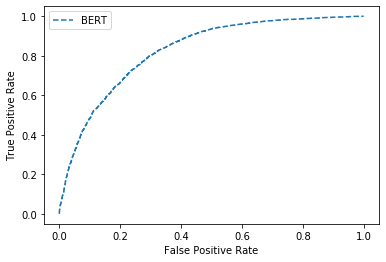

In [50]:
import matplotlib.pyplot as plt
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='BERT')
#plt.plot(fpr_ll, tpr_ll, linestyle='-', label='Logistic Regression')
#pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [0]:
results = pd.DataFrame()
results['prob'] = pred.p1
results['predictions'] = pred.labels
results['labels'] = pred.true_labels
results.to_csv('/content/gdrive/My Drive/Colab Notebooks/BERT.csv') 

In [0]:
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [54]:
estimator.evaluate(input_fn=train_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-14T04:18:05Z


INFO:tensorflow:Starting evaluation at 2019-12-14T04:18:05Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-12-14-04:20:18


INFO:tensorflow:Finished evaluation at 2019-12-14-04:20:18


INFO:tensorflow:Saving dict for global step 1390: auc = 0.93833154, eval_accuracy = 0.93833154, f1_score = 0.94034773, false_negatives = 155.0, false_positives = 531.0, global_step = 1390, loss = 0.16763781, precision = 0.9105759, recall = 0.9721323, true_negatives = 5031.0, true_positives = 5407.0


INFO:tensorflow:Saving dict for global step 1390: auc = 0.93833154, eval_accuracy = 0.93833154, f1_score = 0.94034773, false_negatives = 155.0, false_positives = 531.0, global_step = 1390, loss = 0.16763781, precision = 0.9105759, recall = 0.9721323, true_negatives = 5031.0, true_positives = 5407.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1390: OUTPUT_DIR_NAME3/model.ckpt-1390


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1390: OUTPUT_DIR_NAME3/model.ckpt-1390


{'auc': 0.93833154,
 'eval_accuracy': 0.93833154,
 'f1_score': 0.94034773,
 'false_negatives': 155.0,
 'false_positives': 531.0,
 'global_step': 1390,
 'loss': 0.16763781,
 'precision': 0.9105759,
 'recall': 0.9721323,
 'true_negatives': 5031.0,
 'true_positives': 5407.0}